In [1]:
import imageio.v3 as iio
import tqdm
import matplotlib.pyplot as plt
import numpy as np

import drjit as dr
import drjit.nn as nn
from drjit.opt import Adam, GradScaler
from drjit.llvm.ad import (
    Texture2f,
    TensorXf,
    TensorXf16,
    Float16,
    Float32,
    ArrayXf16,
    Array2f,
    Array3f,
)
import mitsuba as mi

mi.set_variant("llvm_ad_rgb")

In [2]:

rng = dr.rng(seed=0)

In [3]:

ref = TensorXf(iio.imread("data/spiral.jpg") / 256)
ref = dr.mean(ref, axis=-1)[:, :, None]
ref = ref / dr.sum(ref, axis=None)
tex = Texture2f(ref)

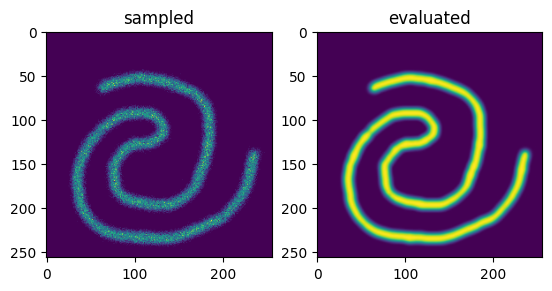

In [4]:

ref_np = ref.numpy()[:, :, 0]
dist_ref = mi.DiscreteDistribution2D(ref_np)

x, _, _ = dist_ref.sample(rng.random(mi.Point2f, (2, 100_000)))
x = mi.Point2f(x) / mi.Vector2f(ref_np.shape[0], ref_np.shape[1])

fig, ax = plt.subplots(1, 2)
hist, _, _ = np.histogram2d(
    x.y,
    x.x,
    bins=ref_np.shape[0],
    density=True,
    range=[
        [0, 1],
        [0, 1],
    ],
)
ax[0].set_title("sampled")
ax[0].imshow(hist)
ax[1].set_title("evaluated")
ax[1].imshow(ref_np)

Normalizing flows can be used to both sample from a learned distribution, but
also evaluate the probability density function for a given sample. This makes
them very useful in computer graphics, where both properties are often
required.

A normalizing flow is represented by an invertible function $f_\theta$. To
sample random variables $X$ from the learned distribution, we sample latent
variables $Z$ from a normal gaussian distribution $Z \sim p_Z = N(0, 1)$, and
apply the inverse flow $X = f^{-1}_\theta(Z)$.

We parameterize the normalizing flows with coupling and permutation layers
$f_{i;\theta}$, such that $X = f_{0;\theta} \circ f_{1;\theta} \circ \dots
f_{D;\theta} (Z)$. To train the network, we maximize the log sum of the
estimated probability of sampling the sample i.e. $max \sum \text{log}
p_{X;\theta}(X_i)$. To compute this probability, we can sum over the log
determinant of the layers, $p_{X;\theta}(X) = \text{log} \left\vert \text{det} {\partial z
\over \partial x} \right\vert_{\theta} + \text{log} p_{Z}(Z)$.

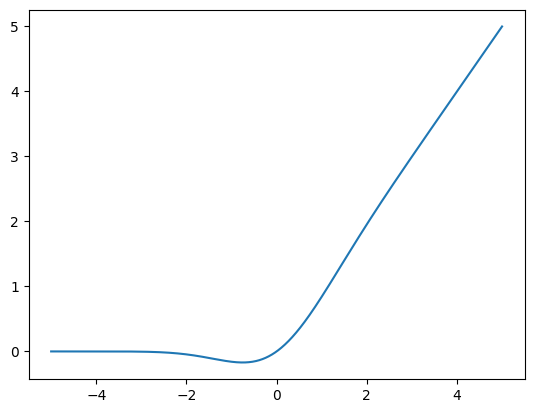

In [5]:


class GELU(nn.Module):
    r""" """

    DRJIT_STRUCT = {}

    def __call__(self, arg: nn.CoopVec, /) -> nn.CoopVec:
        return (
            0.5
            * arg
            * (1 + dr.tanh(dr.sqrt(2 / dr.pi) * (arg + 0.044715 * arg * arg * arg)))
        )


x = dr.linspace(Float32, -5, 5, 1000)
y = GELU()(x)
plt.plot(x, y)

In [6]:


def square_to_std_normal(x: dr.ArrayBase, y: dr.ArrayBase):
    r = dr.sqrt(-2.0 * dr.log(1.0 - x))
    phi = 2.0 * dr.pi * y

    s, c = dr.sincos(phi)
    return c * r, s * r


def std_normal_pdf(z: dr.ArrayBase):
    return dr.inv_two_pi * dr.exp(-0.5 * dr.square(z))


def log_std_normal_pdf(z: dr.ArrayBase):
    return dr.log(std_normal_pdf(z))
    return dr.log(dr.inv_two_pi) + (-0.5 * dr.square(z))


class FlowLayer(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec: ...
    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]: ...


class PermutationLayer(FlowLayer):
    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        z = list(z)
        z.reverse()
        x = nn.CoopVec(z)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        x = list(x)
        x.reverse()
        z = nn.CoopVec(x)
        ldj = Float16(0)
        return z, ldj


class CouplingLayer(FlowLayer):

    DRJIT_STRUCT = {
        "net": nn.Sequential,
        "config": tuple,
    }

    def __init__(
        self, n_layers: int = 4, width: int = 2, n_activations: int = 32
    ) -> None:
        super().__init__()

        self.config = (width,)

        sequential = []
        # sequential.append(nn.SinEncode(octaves=16, shift=0.2))
        sequential.append(nn.Linear(-1, n_activations))
        for i in range(n_layers - 2):
            sequential.append(nn.Linear(n_activations, n_activations))
            sequential.append(nn.ReLU())
        sequential.append(nn.Linear(n_activations, width))

        self.net = nn.Sequential(*sequential)

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        r"""
        This function represents the inverse evaluation of the coupling layer,
        i.e. $X = f^{-1}_\theta(Z)$.
        """
        z: list = list(z)
        d = len(z) // 2
        id, z2 = z[:d], z[d:]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        a, mu = p[:d, :], p[d:, :]
        x2 = (z2 - mu) * dr.exp(-a)
        x = nn.CoopVec(id, x2)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        r"""
        This function evaluates the foward flow $Z = f_\theta(X)$, as well as
        the log jacobian determinant.
        """
        x = list(x)
        d = len(x) // 2
        id, x2 = x[:d], x[d:]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        a, mu = p[:d, :], p[d:, :]
        z2 = x2 * dr.exp(a) + mu
        z = nn.CoopVec(id, z2)
        ldj = dr.sum(a)
        return z, ldj

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        (width,) = self.config
        if width < 0:
            width = size

        net, _ = self.net._alloc(dtype, width // 2, rng)

        result = CouplingLayer()
        result.net = net

        return result, size


class Flow(nn.Module):

    DRJIT_STRUCT = {
        "layers": list[FlowLayer],
    }

    def __init__(self, *args: FlowLayer) -> None:
        super().__init__()
        self.layers = args

    def sample_base_dist(self, sample: nn.CoopVec) -> nn.CoopVec:
        sample = list(sample)
        z = []
        for i in range(0, len(sample), 2):
            x, y = square_to_std_normal(Float32(sample[i]), Float32(sample[i + 1]))
            z.append(Float16(x))
            z.append(Float16(y))

        return nn.CoopVec(*z)

    def eval_base_dist_log(self, z: nn.CoopVec) -> dr.ArrayBase:
        return dr.sum([log_std_normal_pdf(z) for z in z])

    def log_p(self, x: nn.CoopVec) -> Float16:
        """
        This function calculates the log probability of sampling a given value
        `x`.
        """

        log_p = dr.zeros(x.type)

        for layer in self.layers:
            x, ldj = layer.forward(x)
            log_p += Float32(ldj)

        log_p += self.eval_base_dist_log(x)
        return log_p

    def sample(self, sample: nn.CoopVec) -> nn.CoopVec:
        r"""
        Sample a function from the learned target distribution $X \sim
        p_{X;\theta}$, given a sample from the uniform distribution.
        """
        z = self.sample_base_dist(sample)

        for layer in reversed(self.layers):
            z = layer.inverse(z)

        return z

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        layers = []
        for l in self.layers:
            l_new, size = l._alloc(dtype, size, rng)
            layers.append(l_new)

        result = Flow(*layers)
        return result, size

In [7]:

layers = [
    *[CouplingLayer(), PermutationLayer()] * 4,
]
flow = Flow(*layers)

flow: Flow = flow.alloc(TensorXf16, rng=rng)

weights, flow = nn.pack(flow, "training")


x_kl = rng.random(mi.Point2f, (2, 100_000))


def kl_divergence(flow):
    p = tex.eval(x_kl)[0]
    q = dr.exp(Float32(flow.log_p(nn.CoopVec(ArrayXf16(x_kl)))))

    d_kl = p * dr.log(p / q + 1e-5)
    d_kl[p == 0] = 0
    return dr.mean(d_kl, axis=None).numpy().item()

In [8]:

opt = Adam(lr=0.001, params={"weights": Float32(weights)})

scaler = GradScaler()

batch_size = 2**14
n = 1_000
losses = []
d_kls = []

iterator = tqdm.tqdm(range(n))
for it in iterator:
    weights[:] = Float16(opt["weights"])

    x, _, _ = dist_ref.sample(rng.random(mi.Point2f, (2, batch_size)))
    x = mi.Point2f(x) / mi.Vector2f(ref_np.shape[0], ref_np.shape[1])
    x = nn.CoopVec(ArrayXf16(x))

    log_p = flow.log_p(x)
    log_p[dr.isnan(log_p)] = 0
    log_p[dr.isinf(log_p)] = 0
    loss_kl = -dr.mean(log_p)

    dr.backward(scaler.scale(loss_kl))
    scaler.step(opt)

    if (it + 1) % 10 == 0:
        loss = loss_kl.numpy().item()
        losses.append(loss)
        d_kl = kl_divergence(flow)
        d_kls.append(d_kl)
        iterator.set_postfix({"loss_kl": loss, "d_kl": d_kl})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:44<00:00,  6.07it/s, loss_kl=1.7, d_kl=inf]


Text(0.5, 0, 'it')

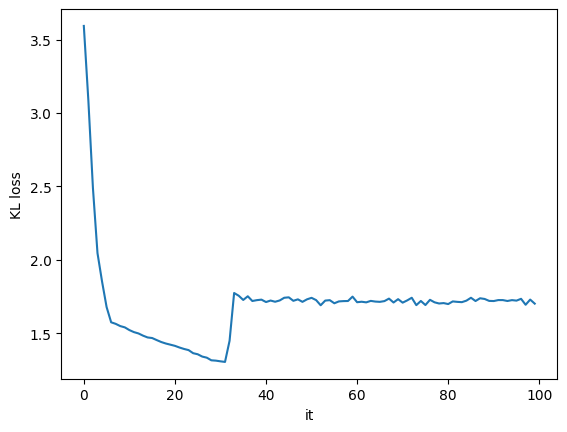

In [9]:

plt.plot(losses)
plt.ylabel("KL loss")
plt.xlabel("it")

Text(0.5, 0, 'it')

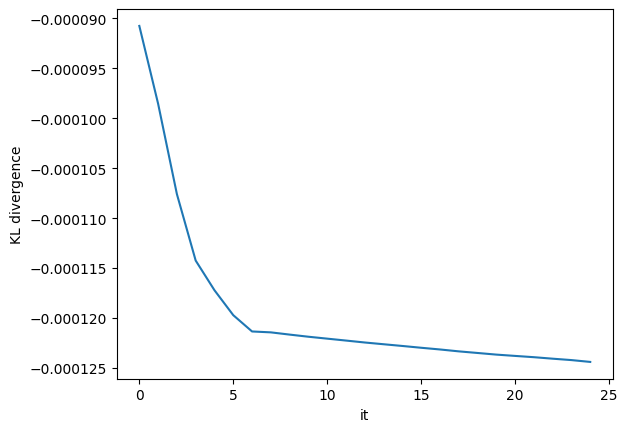

In [10]:
plt.plot(d_kls)
plt.ylabel("KL divergence")
plt.xlabel("it")

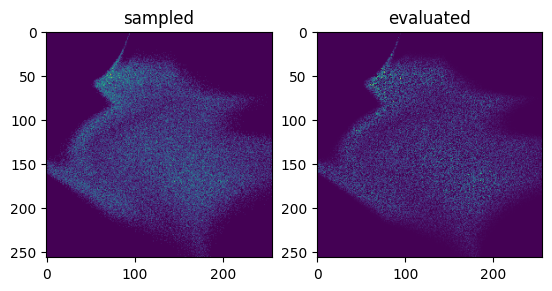

In [11]:

x = ArrayXf16(flow.sample(nn.CoopVec(rng.random(ArrayXf16, (2, 100_000)))))
hist, _, _ = np.histogram2d(
    x[1], x[0], bins=ref_np.shape[0], density=True, range=[[0, 1], [0, 1]]
)

x = rng.random(ArrayXf16, (2, 100_000))
log_p = flow.log_p(nn.CoopVec(x))
p = dr.exp(log_p)
hist2, _, _ = np.histogram2d(
    x[1],
    x[0],
    bins=ref_np.shape[0],
    density=True,
    weights=p,
    range=[[0, 1], [0, 1]],
)

fig, ax = plt.subplots(1, 2)

ax[0].set_title("sampled")
ax[0].imshow(hist)
ax[1].set_title("evaluated")
ax[1].imshow(hist2)